# VQE for Lithium Hydride (LiH) - Frozen Core Version (8 Qubits)

This notebook uses **frozen core approximation** to reduce LiH from 12 qubits → 8 qubits.

**Optimizations:**
- Frozen core: Li 1s orbital frozen (reduces 6→4 spatial orbitals)
- Result: 8 qubits instead of 12
- **10-20x faster** while maintaining chemical accuracy!


In [27]:
# Install required packages
!pip install --upgrade qiskit qiskit-nature qiskit-algorithms pyscf matplotlib -q


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [28]:
# Import required libraries
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit.circuit.library import ExcitationPreserving  
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import StatevectorEstimator
import matplotlib.pyplot as plt
import numpy as np
import time

## Step 1: Define LiH Molecule with Frozen Core

In [29]:
# Define LiH molecule
driver = PySCFDriver(
    atom="Li 0 0 0; H 0 0 1.595",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

# Run electronic structure calculation
problem_full = driver.run()

print(f"Before freeze-core:")
print(f"  Spatial orbitals: {problem_full.num_spatial_orbitals}")
print(f"  Particles:        {problem_full.num_particles}")
print(f"  Qubits:           {problem_full.num_spatial_orbitals * 2}\n")

# Apply frozen core approximation
# freeze_core=True: freezes Li 1s core (2 electrons) → reduces 6→5 spatial orbitals = 10 qubits
# To get 8 qubits (4 spatial orbitals), also remove 1 high-energy orbital
transformer = FreezeCoreTransformer(
    freeze_core=True,
    #remove_orbitals=[4, 5]  # Remove 2 high-energy orbitals: 6→4 spatial orbitals
    remove_orbitals=[5] 
)
problem = transformer.transform(problem_full)

print(f"After freeze-core:")
print(f"  Spatial orbitals: {problem.num_spatial_orbitals}")
print(f"  Particles:        {problem.num_particles}")
print(f"  Qubits:           {problem.num_spatial_orbitals * 2} ✅ (Target: 8)")
print(f"  Nuclear repulsion: {problem.nuclear_repulsion_energy:.6f} Ha")

Before freeze-core:
  Spatial orbitals: 6
  Particles:        (2, 2)
  Qubits:           12

After freeze-core:
  Spatial orbitals: 4
  Particles:        (1, 1)
  Qubits:           8 ✅ (Target: 8)
  Nuclear repulsion: 0.995318 Ha


## Step 2: Get Hamiltonian and Map to Qubits


In [30]:
# Get Hamiltonian from reduced problem
hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

# Map to qubit operator
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)

print(f"Fermionic operator has {len(second_q_op)} terms")
print(f"Qubit operator has {len(qubit_op)} terms")
print(f"Number of qubits: {qubit_op.num_qubits}")


Fermionic operator has 300 terms
Qubit operator has 105 terms
Number of qubits: 8


## Step 3: Exact Solution (NumPy Solver)


In [31]:
# Exact solver for reference
numpy_solver = NumPyMinimumEigensolver()
numpy_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

exact_electronic = numpy_result.eigenvalue.real
exact_total = exact_electronic + problem.nuclear_repulsion_energy

print("Exact Solution (NumPy):")
print(f"  Electronic energy: {exact_electronic:.8f} Ha")
print(f"  Total energy:      {exact_total:.8f} Ha")


Exact Solution (NumPy):
  Electronic energy: -1.06086814 Ha
  Total energy:      -0.06555051 Ha


## Step 4: Create PC-HEA Ansatz


In [32]:
# Create particle-conserving hardware-efficient ansatz (PC-HEA)
ansatz = ExcitationPreserving(
    num_qubits=qubit_op.num_qubits,
    mode="fsim",          # particle-conserving entangling gate
    entanglement="linear",   # fully connected entanglement
    reps=4,                # depth; increase if you want more expressivity
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

print("PC-HEA ansatz created:")
print(f"  Parameters: {ansatz.num_parameters}")
print(f"  Circuit depth: {ansatz.decompose().depth()}")
print(f"  Qubits: {ansatz.num_qubits}")

PC-HEA ansatz created:
  Parameters: 96
  Circuit depth: 32
  Qubits: 8


/var/folders/9w/z96h_sv173zg03wdq5d17txm0000gn/T/ipykernel_93184/3162328603.py:2: DeprecationWarning: The class ``qiskit.circuit.library.n_local.excitation_preserving.ExcitationPreserving`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.excitation_preserving instead.
  ansatz = ExcitationPreserving(


## Step 5: Run VQE with SPSA Optimizer


In [33]:
# Run VQE with SPSA optimizer
convergence_history = []
start_time = time.time()

def callback(eval_count, parameters, mean, std):
    """Callback to track progress"""
    convergence_history.append(mean)
    elapsed = time.time() - start_time
    #if len(convergence_history) % 10 == 0:
        #print(f"Eval {len(convergence_history)}: Energy = {mean:.6f} Ha (Time: {elapsed:.1f}s)")

vqe_solver = VQE(
    StatevectorEstimator(),
    ansatz,
    SPSA(
        maxiter=1000,
        learning_rate=0.01,   # explicitly set to avoid bad auto-calibration
        perturbation=0.05,
    ),
    callback=callback,
)

vqe_solver.initial_point = [0.0] * ansatz.num_parameters

print("Running VQE with SPSA optimizer...")
print("(SPSA: 2 evals/iter instead of ~parameters for gradient-based)\\n")
result = vqe_solver.compute_minimum_eigenvalue(qubit_op)

vqe_electronic = result.eigenvalue.real
vqe_total = vqe_electronic + problem.nuclear_repulsion_energy

print(f"\\n{'='*60}")
print("VQE Solution:")
print(f"  Electronic energy: {vqe_electronic:.8f} Ha")
print(f"  Total energy:      {vqe_total:.8f} Ha")
print(f"  Total evaluations: {len(convergence_history)}")
print(f"  Total time: {time.time() - start_time:.1f} seconds")
print(f"{'='*60}")


Running VQE with SPSA optimizer...
(SPSA: 2 evals/iter instead of ~parameters for gradient-based)\n
\n============================================================
VQE Solution:
  Electronic energy: -1.05905031 Ha
  Total energy:      -0.06373267 Ha
  Total evaluations: 2001
  Total time: 10.4 seconds


## Step 6: Compare VQE vs Exact Solution


In [34]:
print("=" * 70)
print("COMPARISON: VQE vs Exact NumPy Solver for LiH (Frozen Core)")
print("=" * 70)

print(f"\nElectronic Energy:")
print(f"  VQE:        {vqe_electronic:.8f} Ha")
print(f"  NumPy:      {exact_electronic:.8f} Ha")
print(f"  Error:      {abs(vqe_electronic - exact_electronic):.8f} Ha")
print(f"  Error (%):  {abs(vqe_electronic - exact_electronic) / abs(exact_electronic) * 100:.6f}%")

print(f"\nTotal Ground State Energy:")
print(f"  VQE:        {vqe_total:.8f} Ha")
print(f"  NumPy:      {exact_total:.8f} Ha")
print(f"  Error:      {abs(vqe_total - exact_total):.8f} Ha")

print(f"\nSystem Properties:")
print(f"  Nuclear repulsion: {problem.nuclear_repulsion_energy:.8f} Ha")
print(f"  Number of qubits: {qubit_op.num_qubits} (reduced from 12)")
print(f"  Number of parameters: {ansatz.num_parameters}")
print("=" * 70)


COMPARISON: VQE vs Exact NumPy Solver for LiH (Frozen Core)

Electronic Energy:
  VQE:        -1.05905031 Ha
  NumPy:      -1.06086814 Ha
  Error:      0.00181783 Ha
  Error (%):  0.171354%

Total Ground State Energy:
  VQE:        -0.06373267 Ha
  NumPy:      -0.06555051 Ha
  Error:      0.00181783 Ha

System Properties:
  Nuclear repulsion: 0.99531764 Ha
  Number of qubits: 8 (reduced from 12)
  Number of parameters: 96


## Step 7: Plot Convergence Diagrams


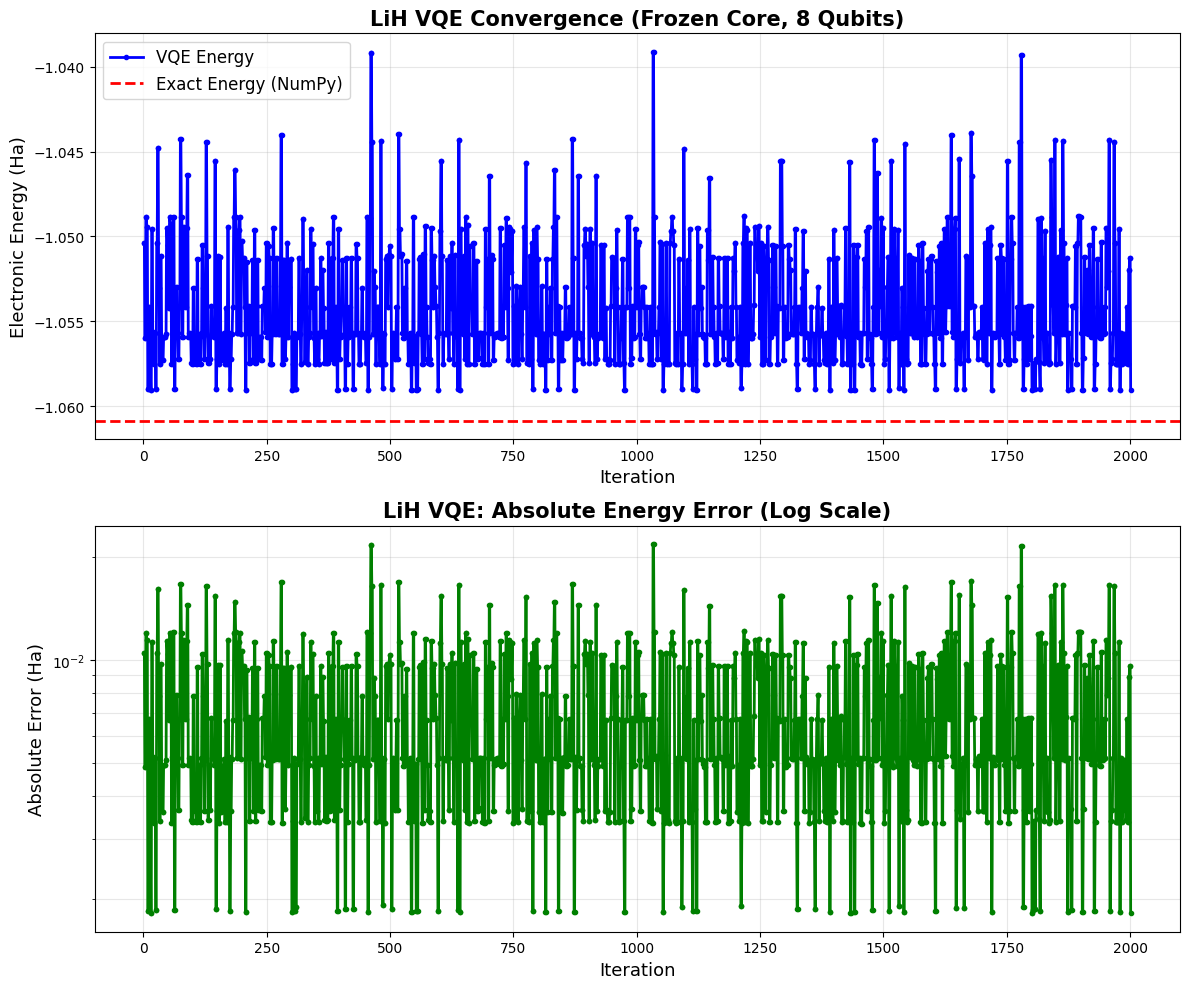


CONVERGENCE STATISTICS
Total iterations:    2001
Initial energy:      -1.05039460 Ha
Final energy:        -1.05905031 Ha
Exact energy:        -1.06086814 Ha
Initial error:       1.05e-02 Ha
Final error:         1.82e-03 Ha
Error reduction:     5.76e+00x


In [35]:
# Create convergence plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

iterations = range(1, len(convergence_history) + 1)

# Plot 1: Energy vs Iteration
ax1.plot(iterations, convergence_history, 'b.-', label='VQE Energy', linewidth=2, markersize=6)
ax1.axhline(y=exact_electronic, color='r', linestyle='--', linewidth=2, label='Exact Energy (NumPy)')
ax1.set_xlabel('Iteration', fontsize=13)
ax1.set_ylabel('Electronic Energy (Ha)', fontsize=13)
ax1.set_title('LiH VQE Convergence (Frozen Core, 8 Qubits)', fontsize=15, fontweight='bold')
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Plot 2: Absolute Error vs Iteration (log scale)
absolute_errors = [abs(energy - exact_electronic) for energy in convergence_history]
ax2.semilogy(iterations, absolute_errors, 'g.-', linewidth=2, markersize=6)
ax2.set_xlabel('Iteration', fontsize=13)
ax2.set_ylabel('Absolute Error (Ha)', fontsize=13)
ax2.set_title('LiH VQE: Absolute Energy Error (Log Scale)', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# Print convergence statistics
print("\n" + "=" * 70)
print("CONVERGENCE STATISTICS")
print("=" * 70)
print(f"Total iterations:    {len(convergence_history)}")
print(f"Initial energy:      {convergence_history[0]:.8f} Ha")
print(f"Final energy:        {convergence_history[-1]:.8f} Ha")
print(f"Exact energy:        {exact_electronic:.8f} Ha")
print(f"Initial error:       {abs(convergence_history[0] - exact_electronic):.2e} Ha")
print(f"Final error:         {abs(convergence_history[-1] - exact_electronic):.2e} Ha")
if abs(convergence_history[-1] - exact_electronic) > 1e-15:
    print(f"Error reduction:     {abs(convergence_history[0] - exact_electronic) / abs(convergence_history[-1] - exact_electronic):.2e}x")
print("=" * 70)
